#### 安裝套件

In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.io as sio
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
from sklearn import preprocessing, linear_model
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold, GridSearchCV
sns.set()
sns.set_palette("hls", 8)

#### method

- 輸出模型準確率和繪製混淆矩陣

In [2]:
def output(model,x_train,y_train,S_test) :    
    accuracy_train = model.score(x_train, y_train)
    accuracy_test = model.score(S_test, y_test)
    print("Training Accuracy:",accuracy_train)
    print("Testing Accuracy:",accuracy_test)
    y_pred = model.predict(S_test)
    cm = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
    fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
    sns.heatmap(cm, 
                xticklabels=['0', '1'],
                yticklabels=['0', '1'],
                annot=True,fmt='g',ax=ax1,
                linewidths=.2,linecolor="Darkblue", cmap="Blues")
    plt.title('Confusion Matrix', fontsize=14)
    plt.show()

#### 載入訓練集

In [3]:
col = ["ID","Default","SP500","TreasuryRate","DTDLevel","DTDTrend","CashTALevel","CashTATrend"
      ,"NITALevel","NITATrend","SizeLevel","SizeTrend","MB","SIGMA","MediaSentimentScore"]
train = pd.read_excel("2808x15.xlsx",header = None)
train.columns = col
train.head()

,ID,Default,SP500,TreasuryRate,DTDLevel,DTDTrend,CashTALevel,CashTATrend,NITALevel,NITATrend,SizeLevel,SizeTrend,MB,SIGMA,MediaSentimentScore
0,29914,0,0.105748,5.781667,2.991237,-0.304599,0.005914,-0.000994,0.008041,0.003846,-6.169169,0.007151,1.486400,0.036054,1.498164
1,28534,0,0.080355,0.143333,2.774796,-0.190453,0.001935,-0.000613,0.013437,-0.022110,-4.645193,-0.303917,2.358707,0.122560,1.098612
2,30383,0,-0.233859,1.064167,6.639440,-0.426534,0.120863,-0.061333,0.019804,-0.004771,-3.567252,0.001180,1.949723,0.086757,1.386294
3,31500,0,0.060460,3.265000,10.520049,1.675419,0.078752,0.048442,0.067335,-0.002979,-5.213275,-0.050929,7.015260,0.087311,2.079442
4,28432,0,-0.180336,1.369167,7.599402,-2.004519,0.229821,0.028242,0.035658,0.002757,1.685995,-0.024760,5.117003,0.050768,1.194506


#### 載入測試集

In [4]:
test = sio.loadmat("test") 
test = pd.DataFrame(test["new"])
test.columns = col
comp = pd.concat([train,test])
test.head()

,ID,Default,SP500,TreasuryRate,DTDLevel,DTDTrend,CashTALevel,CashTATrend,NITALevel,NITATrend,SizeLevel,SizeTrend,MB,SIGMA,MediaSentimentScore
0,29914.0,0.0,0.061827,0.305167,4.923900,-1.624164,0.015848,0.011049,0.004482,-0.000320,-5.700290,0.033461,0.981776,0.106913,0.597253
1,28534.0,0.0,0.215487,0.034833,5.975118,-2.911236,0.005365,0.002699,0.013425,-0.010326,-3.801586,-0.439577,3.603628,0.095247,0.693147
2,30383.0,0.0,0.212359,0.038667,14.246041,1.020533,0.175501,-0.035221,0.025523,0.006765,-2.506526,-0.029810,3.274125,0.033265,1.945910
3,29443.0,0.0,0.062598,0.025167,1.915331,-0.873294,0.114398,-0.015987,-0.063591,0.057003,-7.290181,-0.896490,1.500431,0.214144,2.754568
4,31264.0,0.0,0.162887,0.050000,3.349041,0.146269,0.196154,0.004205,0.011779,-0.003595,-2.991021,0.159933,1.459570,0.074337,0.366204


In [5]:
from pymatch.Matcher import Matcher

In [6]:
test = comp[comp["Default"]==1]
control = comp[comp["Default"]==0]

In [7]:
m = Matcher(test, control, yvar="Default", exclude=["ID",'MediaSentimentScore'])

Formula:
Default ~ SP500+TreasuryRate+DTDLevel+DTDTrend+CashTALevel+CashTATrend+NITALevel+NITATrend+SizeLevel+SizeTrend+MB+SIGMA
n majority: 3008
n minority: 699


In [8]:
import warnings
warnings.filterwarnings('ignore')
np.random.seed(20170921)
m.fit_scores(balance=True, nmodels=100)

Fitting Models on Balanced Samples: 100\100
Average Accuracy: 93.56%


In [9]:
m.match(method="min", nmatches=1, threshold=0.0009)
m.record_frequency()

Propensity Scores have not been calculated. Using defaults...
Fitting Models on Balanced Samples: 10\10
Average Accuracy: 93.63%


,freq,n_records
0,1,777
1,2,25
2,3,10
3,4,3
4,5,8
5,6,2
6,7,3
7,8,1
8,9,1
9,10,1


In [10]:
m.assign_weight_vector()

In [11]:
mtest = m.matched_data.sort_values("match_id")

In [12]:
mtest[mtest["Default"]==1].describe()

,record_id,weight,ID,Default,SP500,TreasuryRate,DTDLevel,DTDTrend,CashTALevel,CashTATrend,NITALevel,NITATrend,SizeLevel,SizeTrend,MB,SIGMA,MediaSentimentScore,scores,match_id
count,699.000000,699.0,699.000000,699.0,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,349.000000,1.0,38509.204578,1.0,0.012405,2.903352,0.932806,-0.728808,0.145312,-0.020899,-0.079442,-0.039779,-5.552409,-0.857714,0.869471,0.280060,0.816003,0.898166,349.000000
std,201.928205,0.0,13657.094510,0.0,0.180775,2.109144,1.071320,0.636153,0.192920,0.063403,0.122074,0.133138,1.506288,0.600370,18.319273,0.175181,1.005677,0.196671,201.928205
min,0.000000,1.0,27013.000000,1.0,-0.393149,0.011833,-1.915575,-4.533151,0.000199,-0.401289,-1.359701,-1.151220,-9.728757,-3.348282,-340.063122,0.052238,-1.723067,0.002855,0.000000
25%,174.500000,1.0,31452.000000,1.0,-0.141862,1.000167,0.219481,-1.118909,0.018510,-0.034122,-0.102946,-0.053519,-6.571724,-1.209703,0.126738,0.183859,0.000000,0.916266,174.500000
50%,349.000000,1.0,37055.000000,1.0,0.056611,2.920500,0.826871,-0.654507,0.061368,-0.004004,-0.036240,-0.011885,-5.717377,-0.821696,0.462393,0.240925,0.693147,0.977833,349.000000
75%,523.500000,1.0,43098.500000,1.0,0.156484,4.901667,1.468110,-0.356485,0.193843,0.004798,-0.007789,0.003450,-4.634900,-0.438169,1.090839,0.323604,1.609438,0.995663,523.500000
max,698.000000,1.0,164076.000000,1.0,0.339880,6.008333,6.816453,2.258738,0.961580,0.260453,0.067487,0.764826,1.499231,0.968213,306.693363,1.703276,4.491397,0.999997,698.000000


In [13]:
mtest[mtest["Default"]==0].describe()

,record_id,weight,ID,Default,SP500,TreasuryRate,DTDLevel,DTDTrend,CashTALevel,CashTATrend,NITALevel,NITATrend,SizeLevel,SizeTrend,MB,SIGMA,MediaSentimentScore,scores,match_id
count,699.000000,699.000000,699.000000,699.0,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,2200.409156,0.206009,43194.432046,0.0,0.007612,2.890872,1.019203,-0.646006,0.135505,-0.022056,-0.051272,-0.052366,-5.338323,-0.825641,0.810217,0.295876,0.976657,0.897626,349.000000
std,625.010096,0.312666,19509.524837,0.0,0.150725,1.892391,1.110046,0.632893,0.176818,0.058778,0.157779,0.141293,1.808608,0.504526,11.765685,0.178309,0.869378,0.196426,201.928205
min,771.000000,0.005952,27064.000000,0.0,-0.393149,0.013833,-0.659516,-3.883740,0.002179,-0.350800,-0.998822,-0.644980,-8.319119,-1.913401,-24.463758,0.048751,-0.833961,0.002851,0.000000
25%,1841.000000,0.017544,35445.000000,0.0,-0.110734,0.254167,-0.220221,-0.914791,0.038745,-0.036217,-0.043760,-0.044057,-6.642809,-1.180650,0.175217,0.226242,0.000000,0.916325,174.500000
50%,2175.000000,0.062500,40021.000000,0.0,0.060460,3.265000,0.988640,-0.432342,0.058923,-0.001924,-0.019517,-0.008475,-5.858602,-1.053197,0.419796,0.244332,1.063796,0.979672,349.000000
75%,2468.000000,0.200000,47091.000000,0.0,0.122040,4.473333,1.587415,-0.375216,0.153122,0.000031,-0.018047,0.003151,-4.409596,-0.498848,0.966787,0.328441,1.609438,0.995836,523.500000
max,3669.000000,1.000000,190942.000000,0.0,0.339880,6.008333,7.661529,1.285423,0.942532,0.259871,0.549505,0.141838,0.338177,1.338664,297.562489,1.851365,3.583519,0.995956,698.000000


In [14]:
x = mtest.iloc[:,4:-2]
y = mtest.iloc[:,3]

In [15]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train , y_test = train_test_split(x, y,test_size=0.2 ,random_state=414)
print(x_train.shape, y_train.shape)
print(x_test.shape ,y_test.shape)

(1118, 13) (1118,)
(280, 13) (280,)


In [16]:
mtest

,record_id,weight,ID,Default,SP500,TreasuryRate,DTDLevel,DTDTrend,CashTALevel,CashTATrend,NITALevel,NITATrend,SizeLevel,SizeTrend,MB,SIGMA,MediaSentimentScore,scores,match_id
0,0,1.000000,32065.0,1,0.283508,5.085000,0.086307,-0.513143,0.000199,-0.000007,-0.016454,0.005209,-6.530020,-0.435409,0.555411,0.195891,0.000000,0.983874,0
802,1648,0.083333,33403.0,0,0.196261,4.411667,0.988640,-0.525880,0.042353,0.017875,-0.013452,-0.000827,-5.540663,-0.781453,0.491173,0.343443,1.039721,0.982832,0
1304,2896,0.038462,34420.0,0,-0.110734,0.129167,0.882379,-0.914686,0.098468,-0.070669,-0.155159,-0.027410,-5.543042,-0.832354,-1.412916,0.283899,0.277987,0.973453,1
1,1,1.000000,29690.0,1,0.242616,5.036667,1.686283,-1.477297,0.072509,0.018146,-0.006550,-0.035763,-6.005441,-0.768428,0.454989,0.137869,1.842068,0.973470,1
1069,2468,0.005952,47091.0,0,0.060460,3.265000,-0.310530,-0.420602,0.058923,-0.001924,-0.019517,-0.008475,-5.858602,-1.105631,0.175217,0.244332,0.000000,0.995956,2
2,2,1.000000,28736.0,1,0.283508,5.085000,1.215289,-1.619508,0.026962,0.039266,-0.020610,-0.082383,-5.220132,-1.658265,0.430880,0.246562,1.220680,0.999433,2
3,3,1.000000,33466.0,1,0.281967,5.051667,1.563262,-1.069329,0.010644,-0.002843,0.003499,-0.035563,-6.165693,-0.692513,0.265799,0.145981,2.197225,0.973134,3
1305,2896,0.038462,34420.0,0,-0.110734,0.129167,0.882379,-0.914686,0.098468,-0.070669,-0.155159,-0.027410,-5.543042,-0.832354,-1.412916,0.283899,0.277987,0.973453,3
4,4,1.000000,32336.0,1,0.242616,5.036667,0.644263,-0.157055,0.053958,0.078209,-0.015186,0.017372,-4.863716,-0.178324,1.180024,0.132618,2.197225,0.786865,4
1380,3428,1.000000,164093.0,0,-0.019220,0.197833,0.412227,0.060816,0.318570,-0.012052,-0.167581,-0.042857,-7.121315,0.079076,-6.122941,0.439969,0.553869,0.786384,4


# 資料EDA

- 違約與未違約比例 (訓練集:測試集)

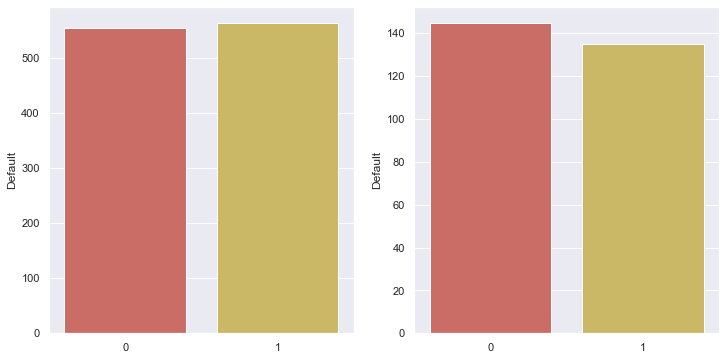

In [17]:
plt.figure(figsize=(12,6))
plt.subplot(121)
dtablefortrain = pd.DataFrame(y_train,columns = ['ID','Default']).Default.value_counts() 
sns.barplot(dtablefortrain.index, dtablefortrain)
plt.subplot(122)
dtablefortest = pd.DataFrame(y_test,columns = ['ID','Default']).Default.value_counts()
sns.barplot(dtablefortest.index, dtablefortest)

- 違約與未違約公司總體環境素質 (訓練集:測試集)

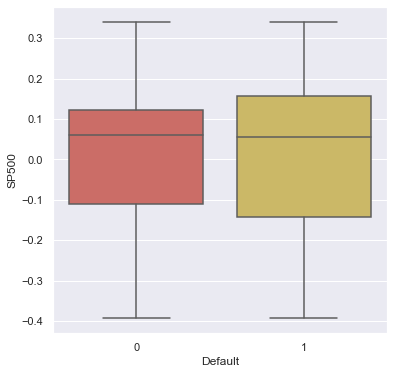

In [18]:
plt.figure(figsize=(6,6))
sns.boxplot("Default" , "SP500" ,data = mtest) 

- 違約與未違約公司媒體情指標 (訓練集:測試集)

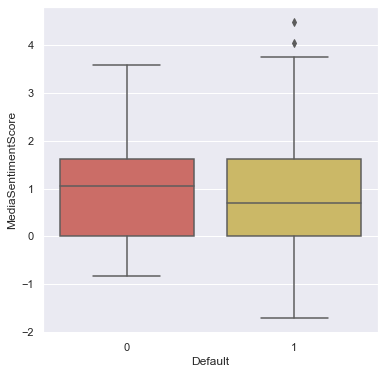

In [19]:
plt.figure(figsize=(6,6))
sns.boxplot("Default" , "MediaSentimentScore" ,data = mtest) 

- 公司成長趨勢與媒體情感指標以違約與否分類

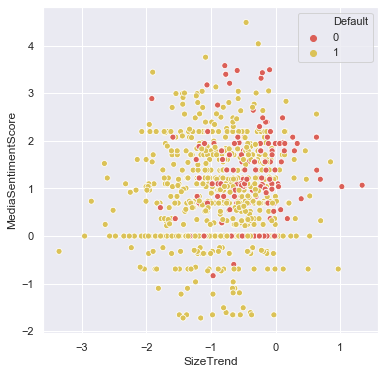

In [20]:
plt.figure(figsize=(6,6))
sns.scatterplot("SizeTrend", "MediaSentimentScore","Default",data = mtest)

- 各變數相關性

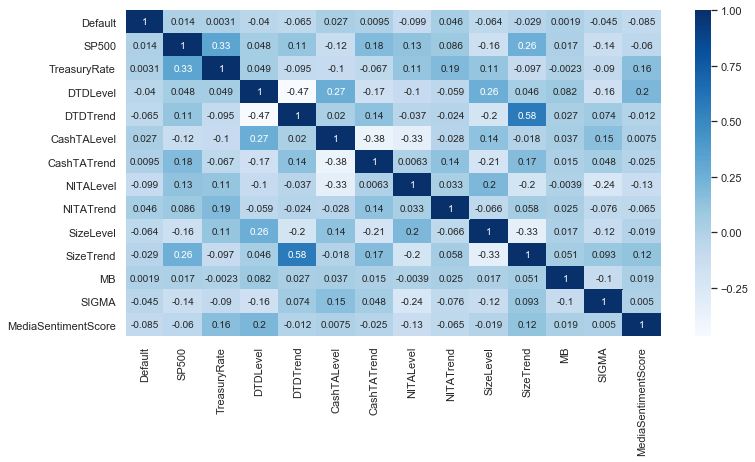

In [21]:
cor = mtest.iloc[:,3:-2].corr() 
plt.figure(figsize=(12,6))
sns.heatmap(cor,cmap='Blues',annot=True)

# 建立模型

## Logistic

In [22]:
from sklearn import preprocessing, linear_model
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold, GridSearchCV
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [23]:
logistic_regr = linear_model.LogisticRegression(C = 6,penalty='l2',random_state=87, class_weight={0: 0.5, 1: 0.5}, solver='newton-cg') # model is built in default
%time logistic_regr.fit(x_train,y_train)

CPU times: user 34.3 ms, sys: 1.51 ms, total: 35.8 ms
Wall time: 34.5 ms


LogisticRegression(C=6, class_weight={0: 0.5, 1: 0.5}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=87, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [24]:
logistic=linear_model.LogisticRegression(random_state=87, class_weight={0: 0.5, 1: 0.5}, solver='newton-cg')
hyperparameters={"C":np.linspace(1,9,9)} 
clf=GridSearchCV(logistic, hyperparameters, cv=5, scoring='recall')
best_model=clf.fit(x_train,y_train)
print("tuned hpyerparameters :(best parameters) ",best_model.best_params_)

tuned hpyerparameters :(best parameters)  {'C': 6.0}


In [25]:
model= linear_model.LogisticRegression(C = 6, penalty='l2', random_state=87) 
scores_accuracy = cross_val_score(model, x_train, y_train, cv=5,scoring='accuracy')
scores_auc = cross_val_score(model, x_train, y_train, cv=5, scoring='roc_auc')
print("Cross-validated scores:", scores_accuracy)
print('average score_accuracy: {}'.format(scores_accuracy.mean()))
print('average score_auc: {}'.format(scores_auc.mean()))

Cross-validated scores: [0.53571429 0.46428571 0.54910714 0.58928571 0.58558559]
average score_accuracy: 0.5447956885456886
average score_auc: 0.5992025225432305


Training Accuracy: 0.5760286225402504
Testing Accuracy: 0.5428571428571428


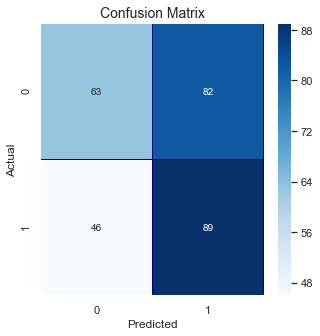

In [26]:
output(logistic_regr,x_train,y_train,x_test)

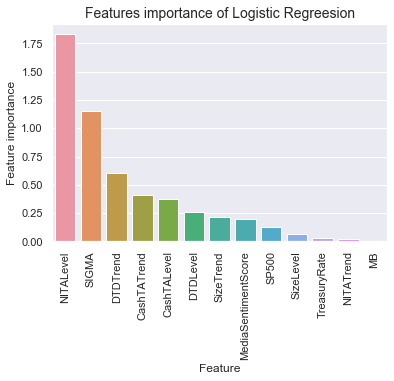

In [27]:
log=np.reshape(abs(logistic_regr.coef_ ), (-1,))
predictors= col[2:]
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': log})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (6,4))
plt.title('Features importance of Logistic Regreesion',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   

## SVM

In [28]:
from sklearn.svm import SVC
svm = SVC(kernel='rbf', probability=True,random_state=87)

In [29]:
%time svm.fit(x_train,y_train)

CPU times: user 159 ms, sys: 3.23 ms, total: 163 ms
Wall time: 172 ms


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=True, random_state=87,
    shrinking=True, tol=0.001, verbose=False)

Training Accuracy: 0.8738819320214669
Testing Accuracy: 0.8607142857142858


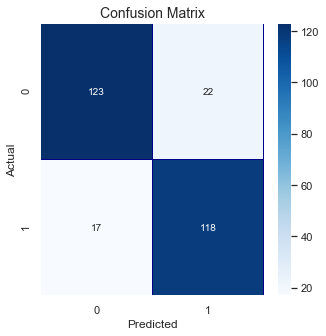

In [30]:
output(svm,x_train,y_train,x_test)

## KNN

In [31]:
from sklearn.neighbors import KNeighborsClassifier

In [32]:
knn = KNeighborsClassifier(n_neighbors=40)
%time knn.fit(x_train,y_train)

CPU times: user 3.06 ms, sys: 2.16 ms, total: 5.22 ms
Wall time: 9.61 ms


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=40, p=2,
                     weights='uniform')

In [33]:
KnnClassifier = KNeighborsClassifier(n_neighbors=1)
hyperparameters={"n_neighbors":np.arange(20,100,10)} 
clf=GridSearchCV(KnnClassifier, hyperparameters, cv=5, scoring='recall')
best_model=clf.fit(x_train,y_train)
print("tuned hpyerparameters :(best parameters) ",best_model.best_params_)

tuned hpyerparameters :(best parameters)  {'n_neighbors': 40}


Training Accuracy: 0.7772808586762076
Testing Accuracy: 0.7678571428571429


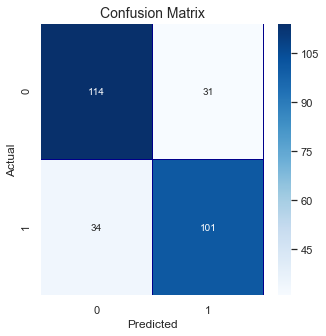

In [34]:
output(knn,x_train,y_train,x_test)

## Random Forest

In [35]:
from sklearn import ensemble

In [36]:
forest = ensemble.RandomForestClassifier(n_estimators = 400, max_features='auto', random_state=87, max_depth=6)
%time forest.fit(x_train,y_train)

CPU times: user 631 ms, sys: 7.62 ms, total: 638 ms
Wall time: 682 ms


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=6, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=87, verbose=0,
                       warm_start=False)

In [37]:
RandomForestClassifier=ensemble.RandomForestClassifier(max_features='auto', random_state=87)
hyperparameters={"n_estimators":np.arange(100,700,100),
                "max_depth":np.linspace(4,6,3)} 
clf=GridSearchCV(RandomForestClassifier, hyperparameters, cv=5, scoring='recall')
best_model=clf.fit(x_train,y_train)
print("tuned hpyerparameters :(best parameters) ",best_model.best_params_)

tuned hpyerparameters :(best parameters)  {'max_depth': 6.0, 'n_estimators': 400}


Training Accuracy: 0.9785330948121646
Testing Accuracy: 0.925


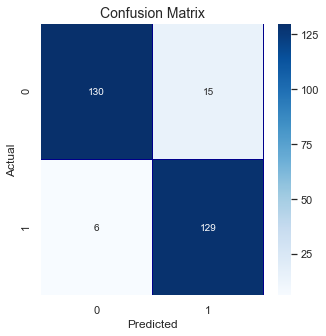

In [38]:
output(forest,x_train,y_train,x_test)

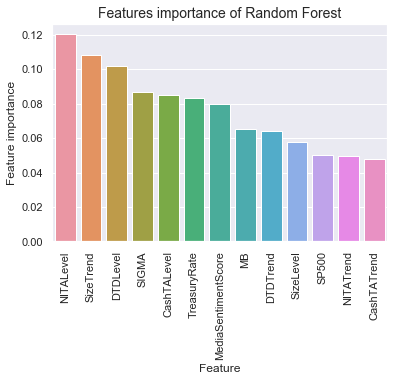

In [39]:
predictors= col[2:]
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': forest.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (6,4))
plt.title('Features importance of Random Forest',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

## XGBOOST

In [40]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost.sklearn import XGBClassifier
from sklearn import metrics

In [41]:
xgb_class = XGBClassifier(random_state=87, n_estimators=80 , max_depth=5, subsample=0.9)
%time xgb_class.fit(x_train,y_train)

CPU times: user 139 ms, sys: 3.14 ms, total: 142 ms
Wall time: 144 ms


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=80, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=87,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, verbosity=1)

In [42]:
xGBClassifier= XGBClassifier(random_state=87, subsample=0.9)
hyperparameters={"n_estimators":np.arange(20,100,20),
                 "max_depth" : np.arange(4,6,1)} 
clf=GridSearchCV(xGBClassifier, hyperparameters, cv=5, scoring='recall')
best_model=clf.fit(x_train,y_train)
print("tuned hpyerparameters :(best parameters) ",best_model.best_params_)

tuned hpyerparameters :(best parameters)  {'max_depth': 5, 'n_estimators': 80}


In [43]:
import warnings
warnings.filterwarnings(module='sklearn*', action='ignore', category=DeprecationWarning)

Training Accuracy: 1.0
Testing Accuracy: 0.95


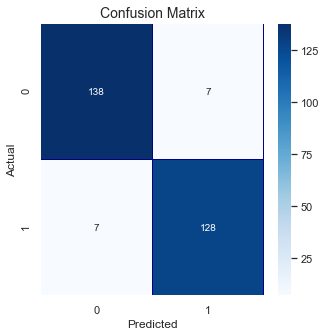

In [44]:
output(xgb_class,x_train,y_train,x_test)

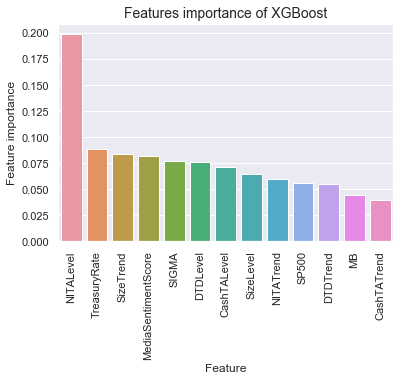

In [45]:
predictors= col[2:]
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': xgb_class.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (6,4))
plt.title('Features importance of XGBoost',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   

## 各模型相關性

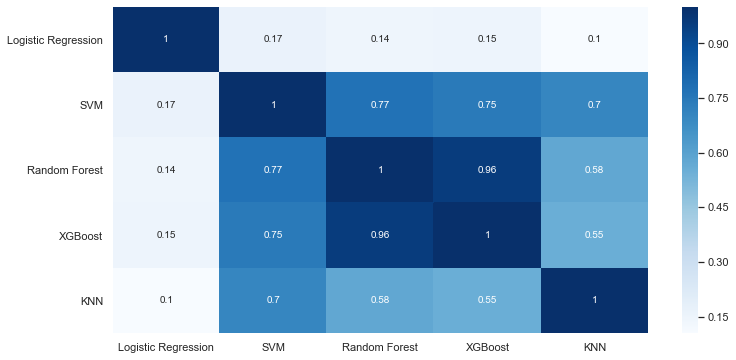

In [46]:
models = {"Logistic Regression":logistic_regr,"SVM":svm,"Random Forest":forest,"XGBoost":xgb_class,"KNN":knn}
def modelcor(modeldict,x):
    predictable = np.zeros((len(x),0))
    for i in modeldict:
        predict = modeldict[i].predict(x)
        predictable = np.column_stack((predictable,predict))
    predictable = pd.DataFrame(predictable)
    predictable.columns = models.keys()
    cor = predictable.corr() 
    plt.figure(figsize=(12,6))
    sns.heatmap(cor,cmap='Blues',annot=True)
modelcor(models,x_train)

## Stacking

In [47]:
from vecstack import stacking

- 第一層

In [70]:
stackmodel1st = [    
    KNeighborsClassifier(n_neighbors=40),
    SVC(kernel='rbf', probability=True),  
    XGBClassifier(random_state=87, n_estimators=80 , max_depth=5, subsample=0.9)
]

In [71]:
%time S_train , S_test = stacking(stackmodel1st, x_train, y_train, x_test, regression=False, mode='oof_pred_bag', needs_proba=True, save_dir=None, n_folds=5, stratified=True, shuffle=True, random_state=87, verbose=2)

task:         [classification]
n_classes:    [2]
metric:       [log_loss]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsClassifier]
    fold  0:  [0.51884092]
    fold  1:  [0.81583537]
    fold  2:  [0.58146037]
    fold  3:  [0.52161208]
    fold  4:  [0.54739030]
    ----
    MEAN:     [0.59702781] + [0.11169933]
    FULL:     [0.59702781]

model  1:     [SVC]
    fold  0:  [0.43200305]
    fold  1:  [0.44183323]
    fold  2:  [0.43182397]
    fold  3:  [0.39432419]
    fold  4:  [0.47611297]
    ----
    MEAN:     [0.43521948] + [0.02611635]
    FULL:     [0.43521948]

model  2:     [XGBClassifier]
    fold  0:  [0.20254877]
    fold  1:  [0.22107326]
    fold  2:  [0.24363786]
    fold  3:  [0.19370769]
    fold  4:  [0.20080187]
    ----
    MEAN:     [0.21235389] + [0.01806646]
    FULL:     [0.21235389]

CPU times: user 739 ms, sys: 14.9 ms, total: 754 ms
Wall time: 829 ms


- 第二層

In [73]:
stackmodel2nd  =linear_model.LogisticRegression(C=0.01, penalty='l2',random_state=87, solver='newton-cg', class_weight={0: 0.5, 1: 0.5})
%time stackmodel2nd.fit(S_train,y_train)

CPU times: user 10.3 ms, sys: 2.27 ms, total: 12.5 ms
Wall time: 11 ms


LogisticRegression(C=0.001, class_weight={0: 0.5, 1: 0.5}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=87, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [74]:
loglin = linear_model.LogisticRegression(penalty='l2',random_state=87, solver='newton-cg', class_weight={0: 0.5, 1: 0.5})
hyperparameters={"C":np.logspace(-3,3,7)} 
clf=GridSearchCV(loglin, hyperparameters, cv=5, scoring='recall')
best_model=clf.fit(S_train,y_train)
print("tuned hpyerparameters :(best parameters) ",best_model.best_params_)

tuned hpyerparameters :(best parameters)  {'C': 0.01}


Training Accuracy: 0.9059701492537313
Testing Accuracy: 0.9107142857142857


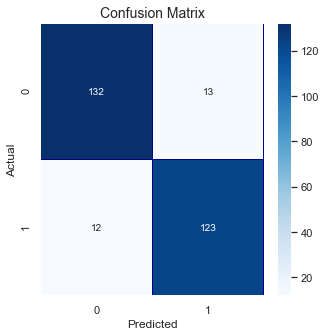

In [75]:
output(stackmodel2nd,S_train,y_train,S_test)

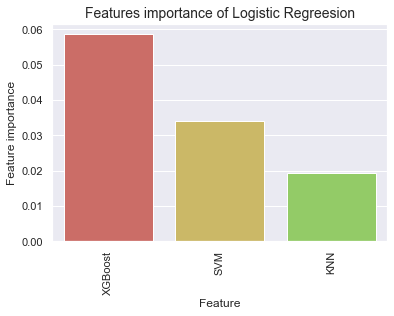

In [76]:
log=np.reshape(abs(stackmodel2nd.coef_ [0][0::2]), (-1,))
predictors= ["KNN","SVM","XGBoost"]
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': log})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (6,4))
plt.title('Features importance of Logistic Regreesion',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show() 

## Blending

### 拆分訓練集驗證集

In [77]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.4,random_state=426)
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)                                         

(402, 13) (402,)
(268, 13) (268,)


### KNN

In [87]:
bknn = KNeighborsClassifier(n_neighbors=40)
bknn.fit(np.array(x_train),y_train)
predict_knn = bknn.predict_proba(np.array(x_val))

### SVM

In [88]:
bsvm = SVC(kernel='rbf', probability=True)
bsvm.fit(x_train,y_train)
predict_svm = bsvm.predict_proba(x_val)

### XGBoost

In [89]:
bxgb = XGBClassifier(random_state=87, n_estimators=80 , max_depth=5, subsample=0.9)
bxgb.fit(np.array(x_train),y_train)
predict_xgb = bxgb.predict_proba(np.array(x_val))

### 集合特徵

In [90]:
B_train=np.concatenate((predict_xgb,predict_svm,predict_knn),axis=1)
print(B_train.shape)

(268, 6)


### 測試集經過第一層模型

In [91]:
x_test2=np.array(x_test)
test_svm = bsvm.predict_proba(x_test2)
test_xgb = bxgb.predict_proba(x_test2)
test_knn = bknn.predict_proba(x_test2)
B_test=np.concatenate((test_xgb,test_svm,test_knn),axis=1)
print(B_test.shape)

(280, 6)


### Logistic(第二層)

In [92]:
blogistic_regr= linear_model.LogisticRegression(C=0.001, penalty='l2',random_state=87, class_weight={0: 0.5, 1: 0.5})
%time blogistic_regr.fit(B_train,y_val)

CPU times: user 1.28 ms, sys: 816 µs, total: 2.1 ms
Wall time: 2.04 ms


LogisticRegression(C=0.001, class_weight={0: 0.5, 1: 0.5}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=87, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [93]:
loglinb = linear_model.LogisticRegression(penalty='l2',random_state=87, solver='newton-cg', class_weight={0: 0.5, 1: 0.5})
hyperparameters={"C":np.logspace(-3,3,7)} 
clf=GridSearchCV(loglinb, hyperparameters, cv=5, scoring='recall')
best_model=clf.fit(B_train,y_val)
print("tuned hpyerparameters :(best parameters) ",best_model.best_params_)

tuned hpyerparameters :(best parameters)  {'C': 0.001}


Training Accuracy: 0.8731343283582089
Testing Accuracy: 0.8678571428571429


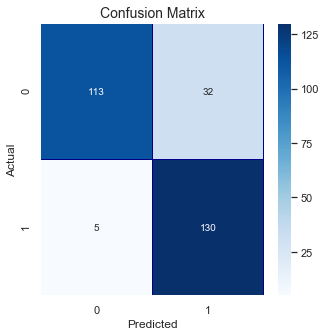

In [94]:
output(blogistic_regr,B_train,y_val,B_test)

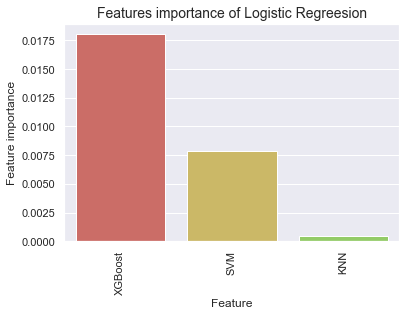

In [95]:
log=np.reshape(abs(blogistic_regr.coef_ [0][0::2]), (-1,))
predictors= ["XGBoost","SVM","KNN"]
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': log})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (6,4))
plt.title('Features importance of Logistic Regreesion',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show() 

# 各模型ROC

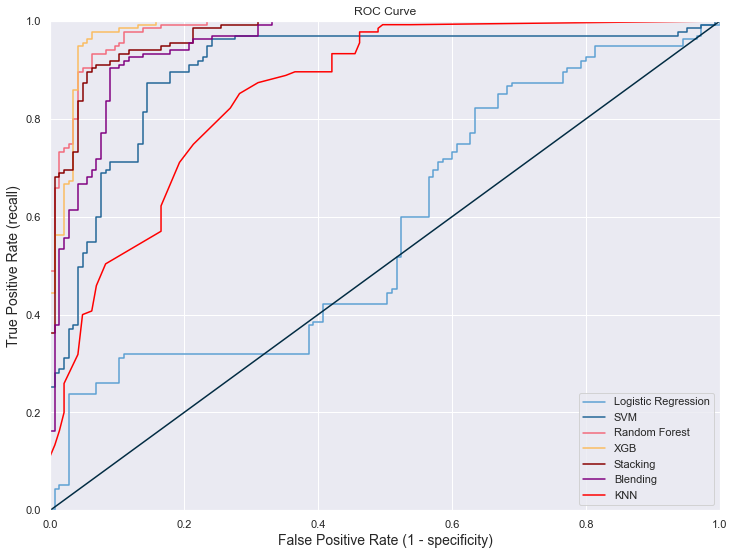

In [96]:
from sklearn.metrics import roc_curve, auc

y_pred_proba1 = logistic_regr.predict_proba(x_test)[:, 1]
[fpr1, tpr1, thr1] = roc_curve(y_test, y_pred_proba1)
plt.figure(figsize=(12,9))
plt.plot(fpr1, tpr1, color='#5ca0d3', label='Logistic Regression')

y_pred_proba2 = svm.predict_proba(x_test)[:, 1]
[fpr2, tpr2, thr2] = roc_curve(y_test, y_pred_proba2)
plt.plot(fpr2, tpr2, color='#226597', label='SVM')

y_pred_proba3 = forest.predict_proba(x_test)[:, 1]
[fpr3, tpr3, thr3] = roc_curve(y_test, y_pred_proba3)
plt.plot(fpr3, tpr3, color='#f36a7b', label='Random Forest')

y_pred_proba4 = xgb_class.predict_proba(x_test)[:, 1]
[fpr4, tpr4, thr4] = roc_curve(y_test, y_pred_proba4)
plt.plot(fpr4, tpr4, color='#fabc60', label='XGB')

y_pred_proba5 = stackmodel2nd.predict_proba(S_test)[:, 1]
[fpr5, tpr5, thr5] = roc_curve(y_test, y_pred_proba5)
plt.plot(fpr5, tpr5, color='#880000', label='Stacking')

y_pred_proba6 = blogistic_regr.predict_proba(B_test)[:, 1]
[fpr6, tpr6, thr6] = roc_curve(y_test, y_pred_proba6)
plt.plot(fpr6, tpr6, color='#800080', label='Blending')

y_pred_proba7 = knn.predict_proba(x_test)[:, 1]
[fpr7, tpr7, thr7] = roc_curve(y_test, y_pred_proba7)
plt.plot(fpr7, tpr7, color='#FF0000', label='KNN')

plt.plot([0, 1], [0, 1],color='#022c43')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
plt.ylabel('True Positive Rate (recall)', fontsize=14)
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [99]:
from operator import itemgetter
rocdict = [{'name': "Logistic Regresision", 'AUC': auc(fpr1, tpr1)},
                 {'name': "Random Forest", 'AUC': auc(fpr3, tpr3)},
                 {'name': "SVM", 'AUC': auc(fpr2, tpr2)},
                 {'name': "XGBoost", 'AUC': auc(fpr4, tpr4)}, 
                 {'name': "KNN",'AUC': auc(fpr7, tpr7)},
                 {'name': "Stacking",'AUC': auc(fpr5, tpr5)},
                 {'name': "Blending",'AUC': auc(fpr6, tpr6)}
                ]
rocdict.sort(key=itemgetter('AUC'))
for idx,model in enumerate(rocdict):
    print("AUC of",model["name"],":",model["AUC"])

AUC of Logistic Regresision : 0.5778288633461047
AUC of KNN : 0.8555300127713921
AUC of SVM : 0.9051340996168582
AUC of Blending : 0.9528480204342273
AUC of Stacking : 0.9718518518518519
AUC of Random Forest : 0.9809450830140486
AUC of XGBoost : 0.9821711366538953
